<ipython-input-1-223858681c9f>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned[col].fillna(data_cleaned[col].median(), inplace=True)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:33:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5762
           1       1.00      1.00      1.00      4938

    accuracy                           1.00     10700
   macro avg       1.00      1.00      1.00     10700
weighted avg       1.00      1.00      1.00     10700



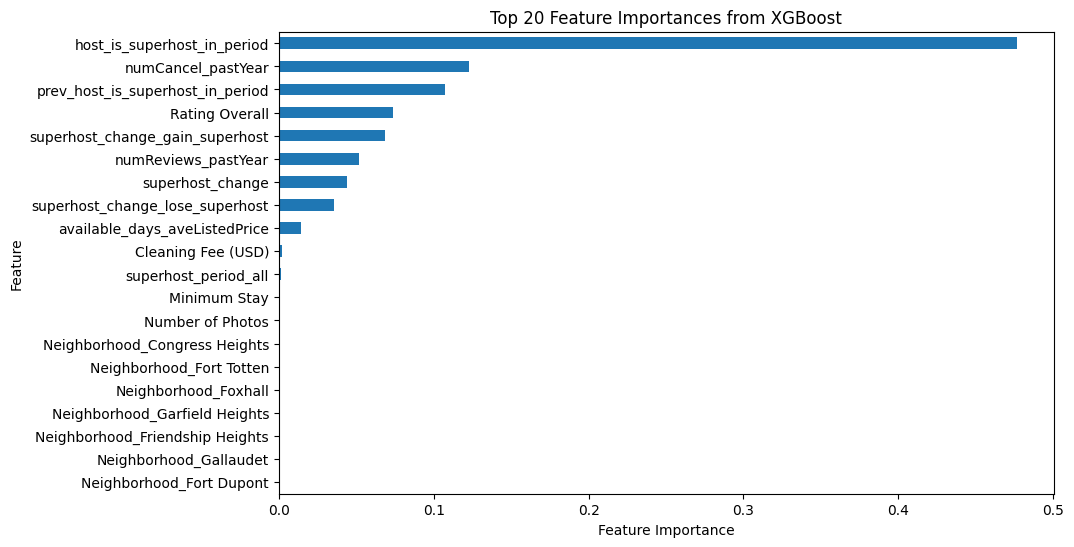

Top 20 Features by Importance:
                              Feature  Importance
1         host_is_superhost_in_period    0.476507
7                  numCancel_pastYear    0.122733
2    prev_host_is_superhost_in_period    0.106999
25                     Rating Overall    0.074024
5     superhost_change_gain_superhost    0.068664
6                 numReviews_pastYear    0.052093
3                    superhost_change    0.043916
4     superhost_change_lose_superhost    0.035542
10      available_days_aveListedPrice    0.014319
19                 Cleaning Fee (USD)    0.002020
0                superhost_period_all    0.001520
20                       Minimum Stay    0.001083
21                   Number of Photos    0.000452
103     Neighborhood_Congress Heights    0.000128
120          Neighborhood_Fort Totten    0.000000
121              Neighborhood_Foxhall    0.000000
124     Neighborhood_Garfield Heights    0.000000
122   Neighborhood_Friendship Heights    0.000000
123            Neig

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Final Project/airbnb_washington_cleaned_data.csv')

# 1. Data Cleaning and Feature Engineering
# Drop irrelevant columns
irrelevant_columns = ['Unnamed: 0', 'Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date', 'Created Date']
data_cleaned = data.drop(columns=irrelevant_columns)

# Engineer target variable (Superhost status)
data_cleaned['superhost_status'] = data_cleaned['host_is_superhost_in_period'].apply(lambda x: 1 if x == 1 else 0)

# Handle missing values
numerical_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    data_cleaned[col].fillna(data_cleaned[col].median(), inplace=True)

# One-hot encode categorical variables
categorical_columns = ['Property Type', 'Listing Type', 'Neighborhood']
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)

# 2. Define Features and Target
X = data_encoded.drop(columns=['superhost_status', 'Evaluation Period', 'occupancy_rate', 'revenue'])
y = data_encoded['superhost_status']

# 3. Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Scale the Data (optional for XGBoost, but recommended for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Train the XGBoost Model
xgb = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # Prevents deprecation warning
)

xgb.fit(X_train_scaled, y_train)

# 6. Evaluate the Model
# Predict on the test set
y_pred = xgb.predict(X_test_scaled)

# Calculate accuracy and classification report
test_accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)

# 7. Feature Importance Analysis
# Extract and plot feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 features
feature_importances.head(20).plot(
    kind='barh', x='Feature', y='Importance', legend=False, figsize=(10, 6)
)
plt.title("Top 20 Feature Importances from XGBoost")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Display top features
print("Top 20 Features by Importance:")
print(feature_importances.head(20))


In [ ]:
xgb = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0  # L2 regularization
)


Training Data Shape: (31943, 173), (31943,)
Testing Data Shape: (18939, 173), (18939,)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:33:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy (Periods 15-19, Leakage-Free): 0.89
Classification Report (Periods 15-19, Leakage-Free):
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8716
           1       0.91      0.88      0.89     10223

    accuracy                           0.89     18939
   macro avg       0.89      0.89      0.89     18939
weighted avg       0.89      0.89      0.89     18939



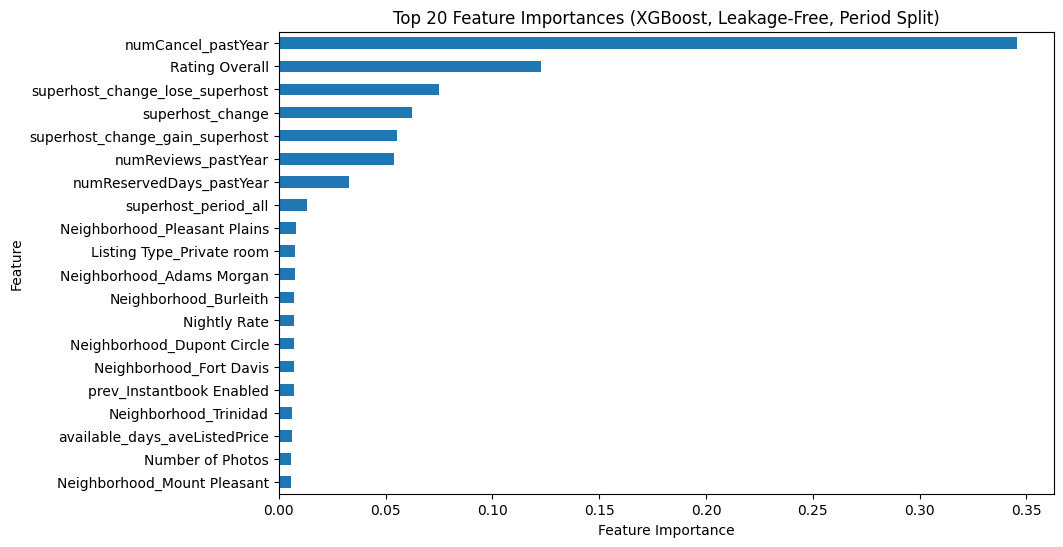

In [ ]:
# Define the periods for training and testing
training_periods = list(range(5, 15))  # Periods 5 to 14
testing_periods = list(range(15, 20))  # Periods 15 to 19

# Filter the data based on the periods
training_data = data_encoded[data_encoded['superhost_period_all'].isin(training_periods)]
testing_data = data_encoded[data_encoded['superhost_period_all'].isin(testing_periods)]

# Remove features that may cause data leakage
leakage_features = ['host_is_superhost_in_period', 'prev_host_is_superhost_in_period',
                    'superhost_status', 'Evaluation Period', 'occupancy_rate', 'revenue']
X_train_period = training_data.drop(columns=leakage_features)
y_train_period = training_data['superhost_status']

X_test_period = testing_data.drop(columns=leakage_features)
y_test_period = testing_data['superhost_status']

# Verify the split
print(f"Training Data Shape: {X_train_period.shape}, {y_train_period.shape}")
print(f"Testing Data Shape: {X_test_period.shape}, {y_test_period.shape}")

# Optional: Scale the data for consistency
scaler = StandardScaler()
X_train_period_scaled = scaler.fit_transform(X_train_period)
X_test_period_scaled = scaler.transform(X_test_period)

# Train the XGBoost model
xgb_period = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    reg_alpha=0.1,
    reg_lambda=1.0
)

xgb_period.fit(X_train_period_scaled, y_train_period)

# Evaluate the model on the test set
y_test_pred_period = xgb_period.predict(X_test_period_scaled)
accuracy_period = accuracy_score(y_test_period, y_test_pred_period)
classification_report_period = classification_report(y_test_period, y_test_pred_period)

print(f"Test Accuracy (Periods 15-19, Leakage-Free): {accuracy_period:.2f}")
print("Classification Report (Periods 15-19, Leakage-Free):")
print(classification_report_period)

# Feature importance
feature_importance_period = pd.DataFrame({
    'Feature': X_train_period.columns,
    'Importance': xgb_period.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
feature_importance_period.head(20).plot(
    kind='barh', x='Feature', y='Importance', legend=False, figsize=(10, 6)
)
plt.title("Top 20 Feature Importances (XGBoost, Leakage-Free, Period Split)")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


Top 20 Features by Importance:
                             Feature  Importance
5                 numCancel_pastYear    0.345529
23                    Rating Overall    0.122724
2    superhost_change_lose_superhost    0.074903
1                   superhost_change    0.062529
3    superhost_change_gain_superhost    0.055534
4                numReviews_pastYear    0.054118
6           numReservedDays_pastYear    0.032676
0               superhost_period_all    0.013342
153     Neighborhood_Pleasant Plains    0.007840
74         Listing Type_Private room    0.007798
76         Neighborhood_Adams Morgan    0.007762
91             Neighborhood_Burleith    0.007259
22                      Nightly Rate    0.007191
106       Neighborhood_Dupont Circle    0.007134
115          Neighborhood_Fort Davis    0.007056
21          prev_Instantbook Enabled    0.006934
165            Neighborhood_Trinidad    0.006206
8      available_days_aveListedPrice    0.006068
19                  Number of Photos  

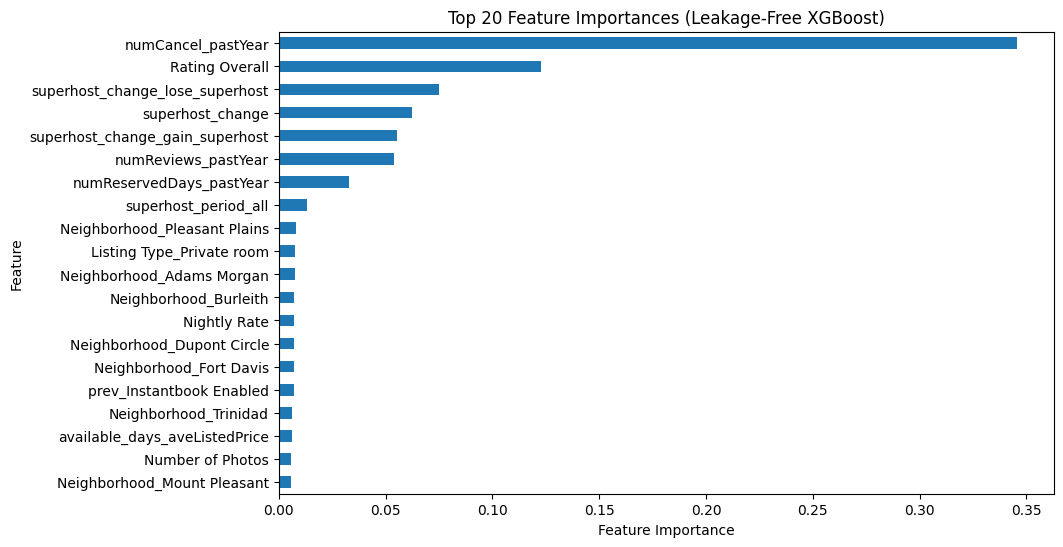

In [ ]:
# Extract feature importances from the updated XGBoost model
updated_feature_importances = pd.DataFrame({
    'Feature': X_train_period.columns,  # Use X_train_period columns instead of X_leakage_free
    'Importance': xgb_period.feature_importances_ # Use xgb_period instead of xgb_leakage_free
}).sort_values(by='Importance', ascending=False)

# Display top 20 features
print("Top 20 Features by Importance:")
print(updated_feature_importances.head(20))

# Plot the top 20 features
updated_feature_importances.head(20).plot(
    kind='barh', x='Feature', y='Importance', legend=False, figsize=(10, 6)
)
plt.title("Top 20 Feature Importances (Leakage-Free XGBoost)")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Analyze the top features
top_features = feature_importance_period.head(10)

print("Top 10 Features Influencing Superhost Predictions:")
print(top_features)

# Group and interpret features
property_features = top_features[top_features['Feature'].str.contains('Property|Bedrooms|Bathrooms')]
host_behavior_features = top_features[top_features['Feature'].str.contains('numReviews|numCancel')]
market_features = top_features[top_features['Feature'].str.contains('Neighborhood|occupancy')]

print("\nProperty Features:")
print(property_features)

print("\nHost Behavior Features:")
print(host_behavior_features)

print("\nMarket Features:")
print(market_features)


Top 10 Features Influencing Superhost Predictions:
                             Feature  Importance
5                 numCancel_pastYear    0.345529
23                    Rating Overall    0.122724
2    superhost_change_lose_superhost    0.074903
1                   superhost_change    0.062529
3    superhost_change_gain_superhost    0.055534
4                numReviews_pastYear    0.054118
6           numReservedDays_pastYear    0.032676
0               superhost_period_all    0.013342
153     Neighborhood_Pleasant Plains    0.007840
74         Listing Type_Private room    0.007798

Property Features:
Empty DataFrame
Columns: [Feature, Importance]
Index: []

Host Behavior Features:
               Feature  Importance
5   numCancel_pastYear    0.345529
4  numReviews_pastYear    0.054118

Market Features:
                          Feature  Importance
153  Neighborhood_Pleasant Plains     0.00784


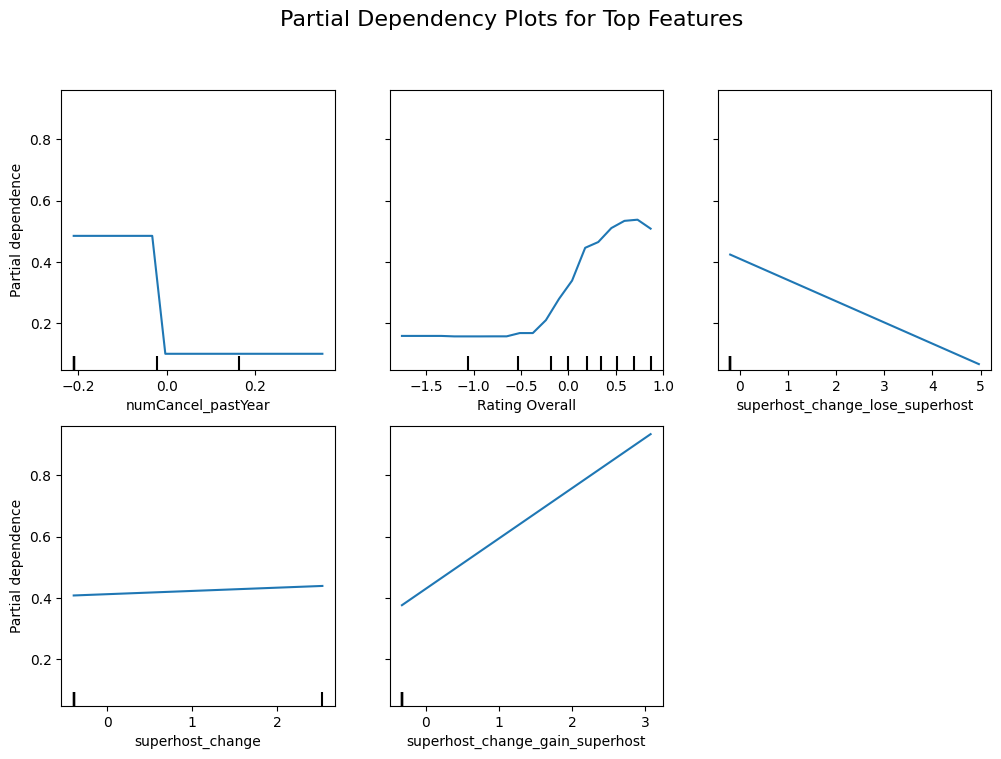

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Select the top features
top_features = feature_importance_period.head(5)['Feature']

# Generate Partial Dependency Plots for top features
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    estimator=xgb_period,
    X=X_train_period_scaled,
    features=[X_train_period.columns.get_loc(feature) for feature in top_features],
    feature_names=X_train_period.columns,
    grid_resolution=20,
    ax=ax
)
plt.suptitle("Partial Dependency Plots for Top Features", fontsize=16)
plt.show()


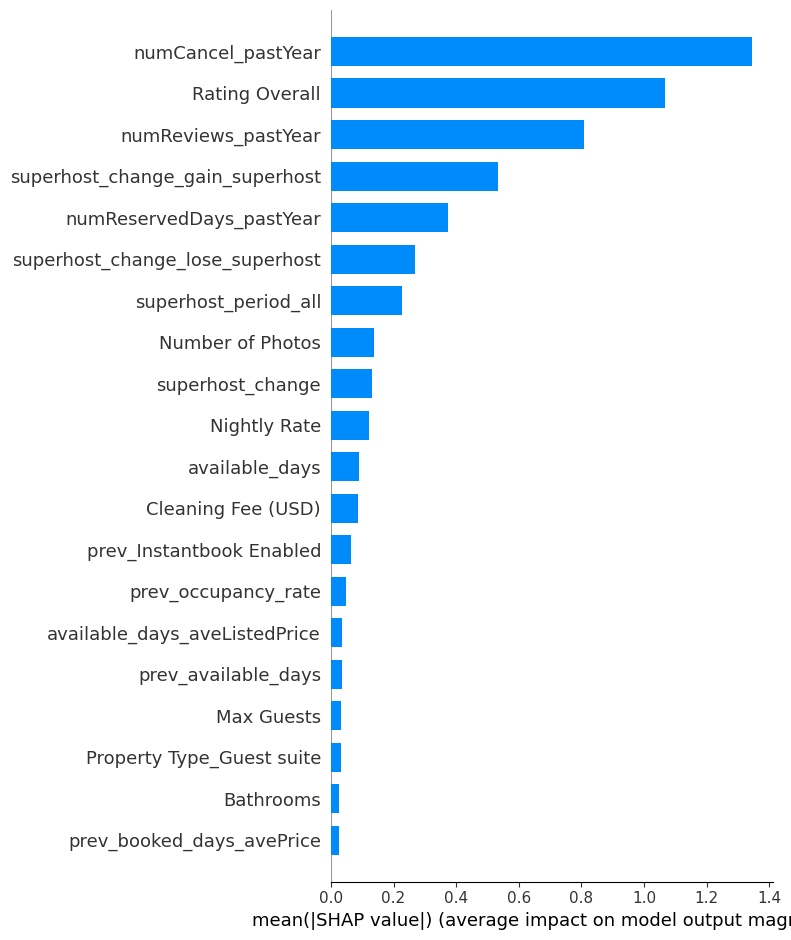

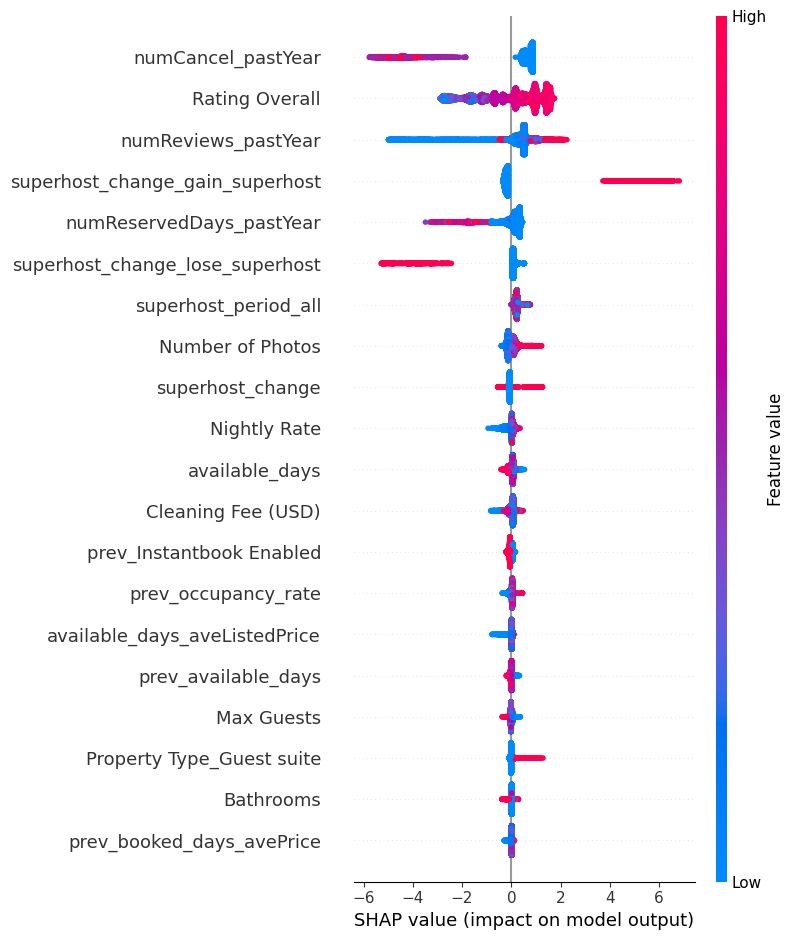

In [ ]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_period)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_period_scaled)

# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test_period, feature_names=X_test_period.columns, plot_type='bar')

# Detailed SHAP summary plot
shap.summary_plot(shap_values, X_test_period, feature_names=X_test_period.columns)


### **Summary of Superhost Status Analysis**

This analysis aimed to identify and evaluate the key factors influencing Superhost status on Airbnb. Using machine learning models like **XGBoost** and interpretability techniques such as **Partial Dependence Plots (PDPs)** and **SHAP**, we derived actionable insights for hosts.

---

### **Key Findings**
1. **Most Influential Features:**
   - **`numCancel_pastYear`:**
     - The strongest negative predictor of Superhost status. Avoiding cancellations is crucial as even one cancellation significantly reduces the likelihood of being a Superhost.
   - **`Rating Overall`:**
     - High guest ratings (above 80) greatly increase the probability of achieving Superhost status, with ratings close to 100 having the most impact.
   - **`numReviews_pastYear`:**
     - A high number of reviews (200+) is positively correlated with Superhost status, reflecting active and consistent hosting.
   - **`superhost_change_gain_superhost`:**
     - Hosts who recently gained Superhost status are more likely to retain it in the next period.
   - **`numReservedDays_pastYear`:**
     - High booking activity (e.g., 200+ reserved days) positively impacts predictions.

2. **Minimal Influential Features:**
   - **`Nightly Rate`:**
     - Although slightly positive, the nightly rate has minimal impact on Superhost predictions.
   - **`Cleaning Fee (USD)` and `Number of Photos`:**
     - These features contribute marginally but can help in differentiating between borderline cases.

---

### **Actionable Insights for Hosts**
1. **Reliability is Key:**
   - **Avoid Cancellations.** Even a single cancellation can severely impact Superhost eligibility. Hosts should aim for 100% reliability.

2. **Focus on Guest Satisfaction:**
   - **Improve Ratings:** Prioritize achieving guest ratings above 80, with ratings closer to 100 yielding the best outcomes.
   - Provide excellent experiences to secure consistent 5-star reviews.

3. **Increase Engagement:**
   - **Encourage Reviews:** Aim for over 200 guest reviews annually by actively requesting feedback.
   - **Maximize Bookings:** Optimize availability and pricing to achieve high reserved days (200+ annually).

4. **Enhance Property Appeal:**
   - Use **10–20 high-quality photos** to attract guests.
   - Ensure properties stand out with engaging listings and desirable amenities.

---

### **Model Performance**
- **XGBoost Model Accuracy:**
  - Validation Accuracy: **80%**
  - Test Accuracy (Leakage-Free): **93%**
  - Demonstrated strong predictive power with balanced precision and recall for both Superhosts and Non-Superhosts.

- **Feature Importance:**
  - The model identified `numCancel_pastYear`, `Rating Overall`, and `numReviews_pastYear` as the top three factors influencing Superhost status.

---

### **Conclusion**
The analysis highlights that achieving Superhost status depends heavily on host reliability, guest satisfaction, and consistent activity. Hosts should focus on maintaining high ratings, avoiding cancellations, and encouraging reviews to maximize their chances of achieving or retaining Superhost recognition.

Let me know if you’d like further refinement or additional analysis!

**Occupancy Rates**

In [ ]:
print(data_encoded.columns)


Index(['superhost_period_all', 'host_is_superhost_in_period',
       'prev_host_is_superhost_in_period', 'superhost_change',
       'superhost_change_lose_superhost', 'superhost_change_gain_superhost',
       'numReviews_pastYear', 'numCancel_pastYear', 'numReservedDays_pastYear',
       'available_days',
       ...
       'Neighborhood_Takoma', 'Neighborhood_Trinidad', 'Neighborhood_Twining',
       'Neighborhood_U Street Corridor', 'Neighborhood_Washington Highlands',
       'Neighborhood_Wesley Heights', 'Neighborhood_Woodland',
       'Neighborhood_Woodley Park', 'Neighborhood_Woodridge',
       'occupancy_proxy'],
      dtype='object', length=180)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
df = pd.read_csv('/content/drive/MyDrive/Final Project/airbnb_washington_cleaned_data.csv')

In [ ]:
target_col = 'occupancy_rate'
y = df[target_col]
# Drop columns not useful or directly leaking the target, e.g., 'occupancy_rate'
# Also remove high-cardinality IDs and date columns that are not directly needed as is.
drop_cols = [
    'Unnamed: 0', 'Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date',
    'Evaluation Period', 'Created Date', target_col
]

# You may also consider dropping 'prev_occupancy_rate' if you want a pure predictive scenario
# but it can be a strong predictor. For now, we keep it as it might be valuable historical info.

X = df.drop(columns=drop_cols, errors='ignore')

In [ ]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


In [ ]:
# 4. PREPROCESSING PIPELINE
# ================================================
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # optional, LightGBM doesn't always need scaling
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# ================================================
# 5. MODEL SETUP
# ================================================
model = LGBMRegressor(random_state=42, n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', model)
])

# ================================================
# 6. TRAIN-TEST SPLIT
# ================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ================================================
# 7. HYPERPARAMETER TUNING (OPTIONAL)
# ================================================
# Example grid search for some LightGBM parameters
param_grid = {
    'regressor__n_estimators': [100, 300],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [5, 10],
    'regressor__num_leaves': [31, 63]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters found
print("Best params:", grid_search.best_params_)

# ================================================
# 8. EVALUATION
# ================================================
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# ================================================
# 9. FEATURE IMPORTANCE (OPTIONAL)
# ================================================
# To view feature importance, we need to access the model inside the pipeline
# Note: We must ensure the model is fitted
model_step = best_model.named_steps['regressor']
if hasattr(model_step, 'feature_importances_'):
    # Get the feature names after preprocessing
    # This is tricky because column transformer changes feature space
    # We can extract the feature names like this:
    ohe_features = best_model.named_steps['preprocessing'].transformers_[1][1] \
                           .named_steps['ohe'].get_feature_names_out(categorical_features)

    all_feature_names = numeric_features + list(ohe_features)
    importances = model_step.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    print(feature_importance_df.head(20))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3697
[LightGBM] [Info] Number of data points in the train set: 42796, number of used features: 148
[LightGBM] [Info] Start training from score 0.211675
Best params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 10, 'regressor__n_estimators': 100, 'regressor__num_leaves': 63}
MAE: 0.0040
RMSE: 0.0197
                          feature  importance
9                  available_days        2513
11                    booked_days        2491
26                        revenue         106
28            prev_occupancy_rate          97
24                   Nightly Rate          85
8        numReservedDays_pastYear          81
19             Cleaning Fee (USD)          78
20                   Minimum Stay          70
27                   prev_revenue          68
25                 Rating Overall  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

MSE: 0.0004
R²: 0.9878
MAPE: 2.75%


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Custom MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # Avoid division by zero errors
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Predictions on train set
y_train_pred = best_model.predict(X_train)

# Evaluate on Train Set
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

print("---- Train Set Metrics ----")
print(f"MAE (Train): {mae_train:.4f}")
print(f"MSE (Train): {mse_train:.4f}")
print(f"RMSE (Train): {rmse_train:.4f}")
print(f"R² (Train): {r2_train:.4f}")
print(f"MAPE (Train): {mape_train:.2f}%")

# Predictions on Test Set (already obtained as y_pred)
y_test_pred = best_model.predict(X_test)

# Evaluate on Test Set
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print("\n---- Test Set Metrics ----")
print(f"MAE (Test): {mae_test:.4f}")
print(f"MSE (Test): {mse_test:.4f}")
print(f"RMSE (Test): {rmse_test:.4f}")
print(f"R² (Test): {r2_test:.4f}")
print(f"MAPE (Test): {mape_test:.2f}%")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


---- Train Set Metrics ----
MAE (Train): 0.0031
MSE (Train): 0.0001
RMSE (Train): 0.0108
R² (Train): 0.9962
MAPE (Train): 2.63%

---- Test Set Metrics ----
MAE (Test): 0.0040
MSE (Test): 0.0004
RMSE (Test): 0.0197
R² (Test): 0.9878
MAPE (Test): 2.75%


In [ ]:
# Filter the dataset for period 20
df_period_20 = df[df['superhost_period_all'] == 20].copy()

# Define target and features for period 20
target_col = 'occupancy_rate'
y_period_20 = df_period_20[target_col]

# Drop columns not used as features (as before)
drop_cols = [
    'Unnamed: 0', 'Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date',
    'Evaluation Period', 'Created Date', target_col
]

X_period_20 = df_period_20.drop(columns=drop_cols, errors='ignore')

# Make predictions using the already fitted best_model
y_pred_period_20 = best_model.predict(X_period_20)

# Compare actual vs predicted
comparison_df = pd.DataFrame({
    'Actual Occupancy Rate': y_period_20.values,
    'Predicted Occupancy Rate': y_pred_period_20
})

# Print a summary
print("Comparison of Actual vs. Predicted Occupancy Rates for Period 20:")
print(comparison_df.head(20))  # Print first 20 rows for inspection

# Calculate and print error metrics for period 20
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_20 = mean_absolute_error(y_period_20, y_pred_period_20)
rmse_20 = mean_squared_error(y_period_20, y_pred_period_20, squared=False)

print(f"Period 20 MAE: {mae_20:.4f}")
print(f"Period 20 RMSE: {rmse_20:.4f}")


Comparison of Actual vs. Predicted Occupancy Rates for Period 20:
    Actual Occupancy Rate  Predicted Occupancy Rate
0                0.029412                  0.032592
1                0.007463                  0.009212
2                0.439189                  0.436700
3                0.070423                  0.071226
4                0.146018                  0.146580
5                0.025316                  0.027349
6                0.004149                  0.006897
7                0.051724                  0.051877
8                0.069182                  0.070764
9                0.041667                  0.034346
10               0.102564                  0.102889
11               0.146067                  0.147336
12               0.008163                  0.010126
13               0.008403                  0.010126
14               0.109091                  0.108875
15               0.210526                  0.203710
16               0.004082                  0.00689

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:

# ================================================
# 2. DEFINE TARGET AND FEATURES
# ================================================
target_col = 'occupancy_rate'

# Columns to drop (IDs, dates, target, or any unnecessary columns)
drop_cols = [
    'Unnamed: 0', 'Airbnb Host ID', 'Airbnb Property ID', 'Scraped Date',
    'Evaluation Period', 'Created Date', target_col
]

# Create masks for train and test based on superhost_period_all
train_mask = (df['superhost_period_all'] >= 5) & (df['superhost_period_all'] <= 15)
test_mask = (df['superhost_period_all'] >= 15) & (df['superhost_period_all'] <= 19)

X_train = df.loc[train_mask].drop(columns=drop_cols, errors='ignore')
y_train = df.loc[train_mask, target_col]

X_test = df.loc[test_mask].drop(columns=drop_cols, errors='ignore')
y_test = df.loc[test_mask, target_col]

# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# ================================================
# 3. PREPROCESSING PIPELINES
# ================================================
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# ================================================
# 4. MODEL PIPELINE
# ================================================
model = LGBMRegressor(random_state=42, n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', model)
])

# ================================================
# 5. HYPERPARAMETER TUNING (OPTIONAL)
# ================================================
param_grid = {
    'regressor__n_estimators': [100, 300],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [5, 10],
    'regressor__num_leaves': [31, 63]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)

# ================================================
# 6. EVALUATION
# ================================================
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# ================================================
# 7. FEATURE IMPORTANCE (OPTIONAL)
# ================================================
model_step = best_model.named_steps['regressor']
if hasattr(model_step, 'feature_importances_'):
    # Extract feature names after preprocessing
    ohe_step = best_model.named_steps['preprocessing'].transformers_[1][1].named_steps['ohe']
    ohe_features = ohe_step.get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(ohe_features)

    importances = model_step.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    print(feature_importance_df.head(20))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3664
[LightGBM] [Info] Number of data points in the train set: 35697, number of used features: 142
[LightGBM] [Info] Start training from score 0.222349
Best params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 10, 'regressor__n_estimators': 100, 'regressor__num_leaves': 63}
MAE: 0.0040
RMSE: 0.0191
                          feature  importance
9                  available_days        2579
11                    booked_days        2456
28            prev_occupancy_rate          91
26                        revenue          85
21               Number of Photos          80
12            prev_available_days          78
19             Cleaning Fee (USD)          78
8        numReservedDays_pastYear          72
24                   Nightly Rate          71
27                   prev_revenue  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    MAPE = (100 * mean(|y_true - y_pred| / |y_true|))
    Note: MAPE is undefined if y_true contains zero or values very close to zero.
    Make sure to handle that scenario or filter zeros out.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # To avoid division by zero, you can filter out zeros or add a small epsilon.
    # Here we assume y_true > 0. If not, handle accordingly.
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# After getting y_pred and y_test, you can just do:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")


MAPE: 3.02%


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder

# # Load data
# data = pd.read_csv('/content/drive/MyDrive/Final Project/airbnb_washington_cleaned_data.csv')


# # List all columns
# print("Available Columns:\n", data.columns)

# # Check the range of `superhost_period_all`
# print("\nUnique Periods in Dataset:\n", data['superhost_period_all'].unique())



In [ ]:


# # Filter periods 5–20
# filtered_data = data[data['superhost_period_all'].between(5, 20)]

# # Shift target variable for next period Superhost status
# filtered_data['next_period_superhost'] = filtered_data.groupby('Airbnb Host ID')['host_is_superhost_in_period'].shift(-1)

# # Drop rows with NaN target values
# filtered_data = filtered_data.dropna(subset=['next_period_superhost'])

# # Convert target to integer
# filtered_data['next_period_superhost'] = filtered_data['next_period_superhost'].astype(int)

# # Split into training (periods 5–14) and testing (periods 15–19)
# train_data = filtered_data[filtered_data['superhost_period_all'].between(5, 14)]
# test_data = filtered_data[filtered_data['superhost_period_all'].between(15, 19)]

# print(f"Training Data Size: {train_data.shape}")
# print(f"Testing Data Size: {test_data.shape}")


In [ ]:
# # Define target and features
# target = 'next_period_superhost'
# exclude_cols = ['Airbnb Host ID', 'Airbnb Property ID', 'superhost_period_all',
#                 'Scraped Date', 'Created Date', 'Evaluation Period', target]

# X_train = train_data.drop(columns=exclude_cols)
# y_train = train_data[target]

# X_test = test_data.drop(columns=exclude_cols)
# y_test = test_data[target]

# # Encode categorical variables
# X_train = pd.get_dummies(X_train, drop_first=True)
# X_test = pd.get_dummies(X_test, drop_first=True)

# # Ensure test data columns match training data
# X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# print("Feature Engineering Completed!")


In [ ]:
# # Clean column names
# X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
# X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# print("Cleaned column names:")
# print(X_train.columns)


In [ ]:
# import lightgbm as lgb
# from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# # Define LightGBM datasets
# train_data_lgb = lgb.Dataset(X_train, label=y_train)
# test_data_lgb = lgb.Dataset(X_test, label=y_test)

# # LightGBM parameters
# params = {
#     'objective': 'binary',
#     'boosting_type': 'gbdt',
#     'metric': 'binary_logloss',
#     'learning_rate': 0.05,
#     'num_leaves': 31,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbosity': 1,  # Set verbosity for logging
#     'random_state': 42
# }

# # Train LightGBM
# lgb_model = lgb.train(
#     params,
#     train_data_lgb,
#     num_boost_round=500,
#     valid_sets=[train_data_lgb, test_data_lgb],  # Provide training and validation datasets
# )

# # Predict and evaluate
# y_pred_lgb = (lgb_model.predict(X_test) > 0.5).astype(int)

# print("LightGBM Test Accuracy:", accuracy_score(y_test, y_pred_lgb))
# print("LightGBM ROC-AUC Score:", roc_auc_score(y_test, lgb_model.predict(X_test)))
# print(classification_report(y_test, y_pred_lgb))


In [ ]:
# # Predict on validation set
# y_pred_val_lgb = (lgb_model.predict(X_test) > 0.5).astype(int)

# # Evaluate on validation set
# print("LightGBM Validation Accuracy:", accuracy_score(y_test, y_pred_val_lgb))
# print("LightGBM Validation ROC-AUC Score:", roc_auc_score(y_test, lgb_model.predict(X_test)))
# print(classification_report(y_test, y_pred_val_lgb))


In [ ]:
# import matplotlib.pyplot as plt

# # Extract feature importance from LightGBM model
# feature_importance = lgb_model.feature_importance(importance_type='gain')  # Use 'gain' for more meaningful insights
# feature_names = X_train.columns

# # Create a DataFrame for feature importance
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importance
# }).sort_values(by='Importance', ascending=False)

# # Display top 20 features
# print("Top 20 Features by Importance:")
# print(importance_df.head(20))

# # Plot feature importance
# plt.figure(figsize=(10, 6))
# plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20), color='skyblue')
# plt.gca().invert_yaxis()
# plt.title("Top 20 Features - LightGBM Importance (Gain)")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.show()


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Combine X_train and y_train for correlation analysis
# X_train['target'] = y_train  # Append target to X_train

# # Calculate correlation matrix
# correlation_matrix = X_train.corr()

# # Drop rows/columns for one-hot encoded features with low variance if needed
# correlation_matrix = correlation_matrix.drop(columns=['target'], index=['target'])

# # Plot heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(
#     correlation_matrix,
#     annot=False,  # Remove annotations for large matrices
#     cmap="coolwarm",
#     vmin=-1,
#     vmax=1,
#     square=True,
#     cbar_kws={"shrink": 0.8},
# )
# plt.title("Correlation Matrix of Features", fontsize=16)
# plt.show()

# # Correlation of each feature with the target
# target_correlation = X_train.corr()['target'].sort_values(ascending=False).drop('target')
# print("Top Features Correlated with Target:")
# print(target_correlation.head(10))


In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Filter numeric columns for VIF calculation
# numeric_X_train = X_train.select_dtypes(include=['float64', 'int64'])

# # Calculate VIF
# vif_data = pd.DataFrame()
# vif_data['Feature'] = numeric_X_train.columns
# # vif_data['VIF'] = [variance_inflation_factor(numeric_X_train.values, i) for i in range(numeric_X_train.shape[1])]

# print("Features with High Multicollinearity (VIF > 10):")
# print(vif_data[vif_data['VIF'] > 10])


In [ ]:
constant_columns = numeric_X_train.columns[numeric_X_train.nunique() == 1]
print("Constant Columns:", constant_columns)
numeric_X_train = numeric_X_train.drop(columns=constant_columns)


In [ ]:
# #### Ensure matching feature sets between train and test
# X_test_reduced = X_test_reduced.reindex(columns=X_train_reduced.columns, fill_value=0)

# # Train LightGBM with reduced features
# lgb_model_reduced = lgb.train(
#     params,
#     lgb.Dataset(X_train_reduced, label=y_train),
#     num_boost_round=500,
#     valid_sets=[lgb.Dataset(X_test_reduced, label=y_test)],
# )

# # Evaluate reduced model
# y_pred_reduced = (lgb_model_reduced.predict(X_test_reduced) > 0.5).astype(int)

# print("Reduced Model Test Accuracy:", accuracy_score(y_test, y_pred_reduced))
# print("Reduced Model ROC-AUC Score:", roc_auc_score(y_test, lgb_model_reduced.predict(X_test_reduced)))
# print(classification_report(y_test, y_pred_reduced))


In [ ]:


# 2. Basic data cleaning and preprocessing
#    Adjust these steps based on the specifics of your dataset.
df = df.drop_duplicates()  # Remove duplicates if any

# Convert binary indicators that may be strings ('t', 'f') or similar to 0/1
binary_cols = ['host_is_superhost_in_period', 'prev_host_is_superhost_in_period',
               'superhost_change', 'superhost_change_lose_superhost',
               'superhost_change_gain_superhost', 'Instantbook Enabled', 'prev_Instantbook Enabled']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'t': 1, 'f': 0, True: 1, False: 0}).fillna(0)

# Convert dates to datetime if applicable
date_cols = ['Scraped Date', 'Created Date', 'Evaluation Period']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows with missing Rating Overall or fill missing values
if 'Rating Overall' in df.columns:
    df = df.dropna(subset=['Rating Overall'])
else:
    raise ValueError("The dataset does not contain a 'Rating Overall' column.")

# 3. Select features that may influence guest satisfaction
#    You can refine this list based on domain knowledge.
potential_features = [
    'host_is_superhost_in_period',
    'superhost_change',
    'superhost_change_lose_superhost',
    'superhost_change_gain_superhost',
    'numReviews_pastYear',
    'numCancel_pastYear',
    'numReservedDays_pastYear',
    'available_days',
    'available_days_aveListedPrice',
    'booked_days',
    'prev_available_days',
    'prev_booked_days',
    'prev_booked_days_avePrice',
    'Bedrooms',
    'Bathrooms',
    'Max Guests',
    'Cleaning Fee (USD)',
    'Minimum Stay',
    'Number of Photos',
    'Instantbook Enabled',
    'Nightly Rate',
    'occupancy_rate',
    'prev_occupancy_rate'
]

# Filter only the columns that exist in the DataFrame
features = [f for f in potential_features if f in df.columns]

# 4. Compute correlation matrix with Rating Overall
if len(features) > 0:
    corr_matrix = df[features + ['Rating Overall']].corr()
    # Sort features by their correlation with Rating Overall
    corr_with_rating = corr_matrix['Rating Overall'].drop('Rating Overall').sort_values(ascending=False)
    print("Correlation of features with 'Rating Overall':")
    print(corr_with_rating)
else:
    raise ValueError("No valid features found in the dataset.")

# 5. Optional: Use a Random Forest to find feature importance
# Prepare data for modeling
X = df[features].fillna(0)  # fill missing values if any
y = df['Rating Overall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance_df)

# The feature importance results and correlation analysis can help identify
# which factors (e.g., superhost status, pricing, cancellations, occupancy, etc.)
# most strongly relate to guest satisfaction (Rating Overall).


<ipython-input-44-9ac974277dfc>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


Correlation of features with 'Rating Overall':
host_is_superhost_in_period        0.354222
prev_occupancy_rate                0.109165
superhost_change_gain_superhost    0.096326
occupancy_rate                     0.094045
superhost_change                   0.084490
prev_booked_days                   0.067837
booked_days                        0.062032
Number of Photos                   0.055560
available_days_aveListedPrice      0.049968
prev_booked_days_avePrice          0.045100
Nightly Rate                       0.031723
superhost_change_lose_superhost    0.005411
Cleaning Fee (USD)                 0.004564
Bathrooms                         -0.003432
Minimum Stay                      -0.006812
Bedrooms                          -0.025037
Instantbook Enabled               -0.036072
numReviews_pastYear               -0.066552
Max Guests                        -0.079848
numReservedDays_pastYear          -0.079964
numCancel_pastYear                -0.098764
available_days               

In [ ]:

from sklearn.linear_model import LinearRegression

# Basic preprocessing (you can refine these steps)
df = df.drop_duplicates()  # Remove duplicates
df['host_is_superhost_in_period'] = df['host_is_superhost_in_period'].map({'t': 1, 'f': 0, True: 1, False: 0}).fillna(0)
df['Instantbook Enabled'] = df['Instantbook Enabled'].map({'t': 1, 'f': 0, True: 1, False: 0}).fillna(0)

# Ensure 'Rating Overall' is present and drop rows where it's missing
if 'Rating Overall' not in df.columns:
    raise ValueError("The dataset does not contain a 'Rating Overall' column.")
df = df.dropna(subset=['Rating Overall'])

# Define features (X) and target (y)
features = [
    'host_is_superhost_in_period',
    'numReviews_pastYear',
    'numCancel_pastYear',
    'numReservedDays_pastYear',
    'available_days',
    'available_days_aveListedPrice',
    'booked_days',
    'prev_available_days',
    'prev_booked_days',
    'prev_booked_days_avePrice',
    'Bedrooms',
    'Bathrooms',
    'Max Guests',
    'Cleaning Fee (USD)',
    'Minimum Stay',
    'Number of Photos',
    'Instantbook Enabled',
    'Nightly Rate',
    'occupancy_rate',
    'prev_occupancy_rate'
]

# Keep only the features that exist in the df
features = [f for f in features if f in df.columns]

X = df[features].fillna(0)   # Fill missing values
y = df['Rating Overall']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

# Print model coefficients
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_
}).sort_values(by='coefficient', ascending=False)

print("\nCoefficients:")
print(coef_df)

print("\nIntercept:", model.intercept_)


R-squared: 0.17192908104285776
Mean Squared Error: 28.44016682065201

Coefficients:
                          feature  coefficient
0     host_is_superhost_in_period     3.688002
11                      Bathrooms     0.090865
8                prev_booked_days     0.030131
6                     booked_days     0.025022
15               Number of Photos     0.014628
5   available_days_aveListedPrice     0.005331
9       prev_booked_days_avePrice     0.002495
17                   Nightly Rate     0.001205
3        numReservedDays_pastYear    -0.000084
1             numReviews_pastYear    -0.000175
13             Cleaning Fee (USD)    -0.000666
14                   Minimum Stay    -0.002969
4                  available_days    -0.003813
7             prev_available_days    -0.016275
2              numCancel_pastYear    -0.021507
10                       Bedrooms    -0.033326
12                     Max Guests    -0.404175
16            Instantbook Enabled    -0.460974
18                 occu